## Import Packages

In [30]:
import sys
sys.path.append('/var/panoptes/panoptes-utils/src')
# sys.path.append('/var/panoptes/panoptes-pipeline/')
# print(sys.path)

In [31]:
import numpy as np
import math
import pandas as pd
import cv2
import astroplan as apl
import astropy.units as u
import matplotlib
import glob
from astropy.time import Time

import matplotlib.animation as animation
from matplotlib.animation import PillowWriter


from astropy.io import fits
# from panoptes.pipeline.scripts import image as image_processing

# NOTE: Many of the PANOPTES utils packages have been deprecated (see https://github.com/panoptes/rtsre-2022) for full tutorial. 
from panoptes.utils.images import fits as fits_utils
from panoptes.utils.images import crop_data
from panoptes.utils.images import bayer

from matplotlib import pyplot as plt
import matplotlib.lines as mlines
from panoptes.utils.images import plot
import seaborn as sb
from astropy.coordinates import SkyCoord
from scipy.stats import median_abs_deviation as md
from astroplan import Observer, FixedTarget, time_grid_from_range

# text_width = 242.26653

## Grab Data

In [3]:
sequence_id = 'PAN012_95cdbc_20200226T031944' # Replace w/ ID for your image sequence.
# base_dir = '/home/jupyter/data'
base_dir = '.'
# sequence_path = sequence_id.replace('_', '/')

In [4]:
# The path for the metadata dataframe if it exists.
images_df_path = f'{base_dir}/{sequence_id}/images-metadata.csv'

Get the metadata from local file.

In [6]:
images_df = pd.read_csv(images_df_path).sort_values(by='time')

In [7]:
images_df

,bucket_path,camera_blue_balance,camera_circconf,camera_colortemp,camera_iso,camera_lens_serial_number,camera_measured_b,camera_measured_ev,camera_measured_ev2,camera_measured_g1,...,mount_ha,mount_ra,public_url,sequence_id,site_elevation,site_latitude,site_longitude,time,unit_id,local_file
0,PAN012/95cdbc/20200226T031944/20200226T032623....,1.471680,0.019,5293,100,HC0205347,690,-3.62,-3.625,1024,...,3.747682,32.775,https://storage.googleapis.com/panoptes-raw-im...,PAN012_95cdbc_20200226T031944,1700.0,34.22,-118.06,2020-02-26 03:26:23+00:00,PAN012,/home/jupyter/data/PAN012_95cdbc_20200226T0319...
1,PAN012/95cdbc/20200226T031944/20200226T032902....,1.471680,0.019,5293,100,HC0205347,688,-3.62,-3.625,1024,...,3.791896,32.775,https://storage.googleapis.com/panoptes-raw-im...,PAN012_95cdbc_20200226T031944,1700.0,34.22,-118.06,2020-02-26 03:29:02+00:00,PAN012,/home/jupyter/data/PAN012_95cdbc_20200226T0319...
2,PAN012/95cdbc/20200226T031944/20200226T033137....,1.471680,0.019,5293,100,HC0205347,689,-3.62,-3.625,1024,...,3.835033,32.775,https://storage.googleapis.com/panoptes-raw-im...,PAN012_95cdbc_20200226T031944,1700.0,34.22,-118.06,2020-02-26 03:31:37+00:00,PAN012,/home/jupyter/data/PAN012_95cdbc_20200226T0319...
3,PAN012/95cdbc/20200226T031944/20200226T033415....,1.471680,0.019,5293,100,HC0205347,687,-3.62,-3.625,1024,...,3.879194,32.775,https://storage.googleapis.com/panoptes-raw-im...,PAN012_95cdbc_20200226T031944,1700.0,34.22,-118.06,2020-02-26 03:34:15+00:00,PAN012,/home/jupyter/data/PAN012_95cdbc_20200226T0319...
4,PAN012/95cdbc/20200226T031944/20200226T033653....,1.473633,0.019,5279,100,HC0205347,688,-3.62,-3.625,1024,...,3.923176,32.775,https://storage.googleapis.com/panoptes-raw-im...,PAN012_95cdbc_20200226T031944,1700.0,34.22,-118.06,2020-02-26 03:36:53+00:00,PAN012,/home/jupyter/data/PAN012_95cdbc_20200226T0319...
5,PAN012/95cdbc/20200226T031944/20200226T033933....,1.471680,0.019,5306,100,HC0205347,690,-3.62,-3.625,1024,...,3.967654,32.775,https://storage.googleapis.com/panoptes-raw-im...,PAN012_95cdbc_20200226T031944,1700.0,34.22,-118.06,2020-02-26 03:39:33+00:00,PAN012,/home/jupyter/data/PAN012_95cdbc_20200226T0319...
6,PAN012/95cdbc/20200226T031944/20200226T034208....,1.471680,0.019,5293,100,HC0205347,687,-3.62,-3.625,1024,...,4.010991,32.775,https://storage.googleapis.com/panoptes-raw-im...,PAN012_95cdbc_20200226T031944,1700.0,34.22,-118.06,2020-02-26 03:42:08+00:00,PAN012,/home/jupyter/data/PAN012_95cdbc_20200226T0319...
7,PAN012/95cdbc/20200226T031944/20200226T034447....,1.471680,0.019,5293,100,HC0205347,688,-3.62,-3.625,1024,...,4.055158,32.775,https://storage.googleapis.com/panoptes-raw-im...,PAN012_95cdbc_20200226T031944,1700.0,34.22,-118.06,2020-02-26 03:44:47+00:00,PAN012,/home/jupyter/data/PAN012_95cdbc_20200226T0319...
8,PAN012/95cdbc/20200226T031944/20200226T034717....,1.471680,0.019,5293,100,HC0205347,691,-3.62,-3.625,1024,...,4.096932,32.775,https://storage.googleapis.com/panoptes-raw-im...,PAN012_95cdbc_20200226T031944,1700.0,34.22,-118.06,2020-02-26 03:47:17+00:00,PAN012,/home/jupyter/data/PAN012_95cdbc_20200226T0319...
9,PAN012/95cdbc/20200226T031944/20200226T034955....,1.471680,0.019,5293,100,HC0205347,689,-3.62,-3.625,1024,...,4.141085,32.775,https://storage.googleapis.com/panoptes-raw-im...,PAN012_95cdbc_20200226T031944,1700.0,34.22,-118.06,2020-02-26 03:49:55+00:00,PAN012,/home/jupyter/data/PAN012_95cdbc_20200226T0319...


Get the list of local paths for the downloaded images.

In [9]:
fits_files = images_df.local_file.to_list()

Get data shape.

In [10]:
np.shape(fits_utils.getdata(fits_files[-1]))

(3476, 5208)

Show list of FITS files.

In [11]:
fits_files

['/home/jupyter/data/PAN012_95cdbc_20200226T031944/20200226T032623.fits',
 '/home/jupyter/data/PAN012_95cdbc_20200226T031944/20200226T032902.fits',
 '/home/jupyter/data/PAN012_95cdbc_20200226T031944/20200226T033137.fits',
 '/home/jupyter/data/PAN012_95cdbc_20200226T031944/20200226T033415.fits',
 '/home/jupyter/data/PAN012_95cdbc_20200226T031944/20200226T033653.fits',
 '/home/jupyter/data/PAN012_95cdbc_20200226T031944/20200226T033933.fits',
 '/home/jupyter/data/PAN012_95cdbc_20200226T031944/20200226T034208.fits',
 '/home/jupyter/data/PAN012_95cdbc_20200226T031944/20200226T034447.fits',
 '/home/jupyter/data/PAN012_95cdbc_20200226T031944/20200226T034717.fits',
 '/home/jupyter/data/PAN012_95cdbc_20200226T031944/20200226T034955.fits',
 '/home/jupyter/data/PAN012_95cdbc_20200226T031944/20200226T035230.fits',
 '/home/jupyter/data/PAN012_95cdbc_20200226T031944/20200226T035739.fits',
 '/home/jupyter/data/PAN012_95cdbc_20200226T031944/20200226T040806.fits',
 '/home/jupyter/data/PAN012_95cdbc_202

Remove bad image (if it exists).

In [13]:
del fits_files[22]
del fits_files[29]

## Display image in sequence.

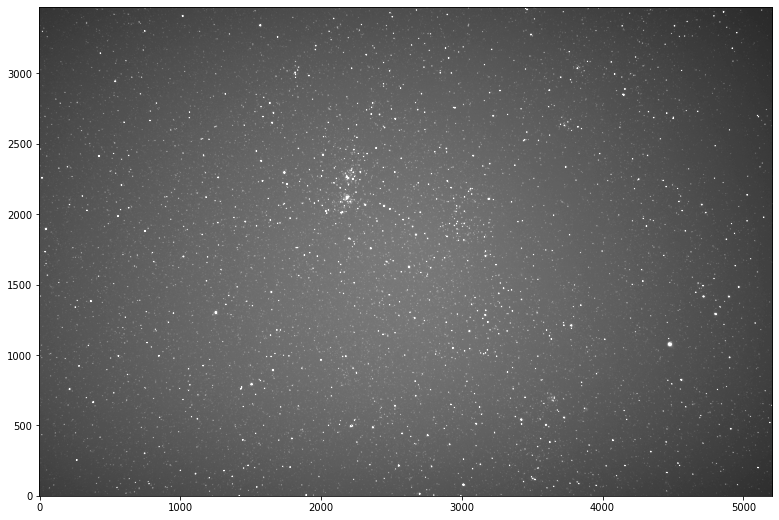

In [14]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
ax.imshow(fits_utils.getdata(fits_files[30]), cmap='gray', origin='lower', vmax='4100')

In [15]:
len(fits_files)

33

Get image data for all FITS and add it to a list

In [16]:
im_data = np.array([fits_utils.getdata(f) for f in fits_files])

Display FITS header.

In [17]:
fits_utils.getheader(fits_files[2])

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                   16 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 5208                                                  
NAXIS2  =                 3476                                                  
FILTER  = 'RGGB    '                                                            
ISO     =                  100                                                  
EXPTIME =                  100                                                  
CAMTEMP = '16 C    '           / Celsius - From CR2                             
CIRCCONF= '0.019 mm'           / From CR2                                       
COLORTMP=                 5293 / From CR2                                       
FILENAME= 'https://storage.googleapis.com/panoptes-incoming/PAN012/95cdbc/2020&'
CONTINUE  '0226T031944/20200

## Process raw data.

In [24]:
def process_images(data=None, stacked_dat=None, channel='green2', target_name='TYC 3697-817-1', stamp_size=(126,126), suppress_output=False):
    """
    A function that plate solves images, extracts postage stamps, and extracts a color channel.
    
    Inputs:
    data (array): The image data to be processed.
    stacked_dat (array): Use if stacking sequence of images.
    channel (string): Specify color channel to be used in extraction.
    target_name: The name of a target to center around.
    stamp_size: Create postage stamp.
    red, green, blue (boolean): Color channels to extract.
    
    Outputs: 
    *color*_arr (array): An image corresponding to an extracted color channel.
    
    """
    wcs0 = fits_utils.getwcs(fits_files[6])
    target_name = target_name
    target_coords = SkyCoord.from_name(target_name)
    target_x, target_y = wcs0.all_world2pix(target_coords.ra, target_coords.dec, 1)
    if data is not None:
        num_frames=len(data)
    else:
        num_frames=len(stacked_dat)
    slice0 = bayer.get_stamp_slice(target_x, target_y, stamp_size=stamp_size)
    if stacked_dat is not None:
        stack_sliced = stacked_dat[slice0]
        sliced_im_stack_arr = np.array(stack_sliced)
        
        if suppress_output is False:
            plt.imshow(sliced_im_stack_arr, origin='lower')
            
        im_rgb_full_stack = bayer.get_rgb_data(data=sliced_im_stack_arr, separate_green=True)
        
        if suppress_output is False:
            print(np.shape(im_rgb_full_stack))
        rgb_dat_stack = im_rgb_full_stack[:, ][~im_rgb_full_stack[:,].mask].reshape(4,int(stamp_size[0]/2),-1)
        if channel == 'red':
            rgb_arr = np.array(rgb_dat_stack[0])
        if channel == 'green1':
            rgb_arr = np.array(rgb_dat_stack[1])
        elif channel == 'green2':
            rgb_arr = np.array(rgb_dat_stack[2])
        elif channel == 'blue':
            rgb_arr = np.array(rgb_dat_stack[3])
#         green1_arr = np.array(green1_stack)
        if suppress_output is False:
            print(f'Stacked Image Shape: {np.shape(green1_stack)}')
            fig=plt.figure(figsize=(25,12))
            ax1 = fig.add_subplot(111)
            ax1.imshow(green1_stack, cmap='gray', origin='lower', vmax = 4100)

            # im_idx = 5
    else:
       # im_idx = 5
        sliced_im_list = []
        for idx in range(len(data)):
            sliced_im_list.append(im_data[idx][slice0])
        sliced_im_arr = np.array(sliced_im_list)
        im_rgb_full = bayer.get_rgb_data(data=sliced_im_arr, separate_green=True)
        rgb_dat_list = []


        for i in range(num_frames):
            rgb_dat_list.append(im_rgb_full[:, i][~im_rgb_full[:,i].mask].reshape(4,int(stamp_size[0]/2), -1))
        rgb_dat_arr = np.array(rgb_dat_list)
        np.shape(rgb_dat_arr)
        # Create green1 channel array
        if channel == 'red':
            rgb_arr = [rgb_dat_list[i][0] for i in range(num_frames)]
        if channel == 'green1':
            rgb_arr = [rgb_dat_list[i][1] for i in range(num_frames)]
        elif channel == 'green2':
            rgb_arr = [rgb_dat_list[i][2] for i in range(num_frames)]
        elif channel == 'blue':
            rgb_arr = [rgb_dat_list[i][3] for i in range(num_frames)]

#         plt.imshow(sliced_im_list[10], origin='lower' )

# plt.savefig('sliced_image.png')
        if suppress_output is False:
            plt.imshow(sliced_im_list[10], origin='lower')
            print(np.shape(im_rgb_full))
            print(f'Stacked Image Shape: {np.shape(rgb_arr)}')
            fig=plt.figure(figsize=(25,12))
            ax1 = fig.add_subplot(111)
            ax1.imshow(rgb_arr, cmap='gray', origin='lower', vmax = 4100)
    return rgb_arr

## Perform photometry.

In [28]:
# Draw square around target star for each frame
def get_flux_counts_new(bin=1, mode='real', pt1_1=25, pt1_2=29, pt2_1=29, pt2_2=25, dims=63, spacing_inner=0, spacing_outer=2, ):
    
    """ Perform aperture photometry on a list of channel-extracted image frames.
    This function will count up all of the values within an inner square and subtract the median values * the number of pixels 
    within the inner square. Each square is drawn from pt1 and pt2--a point corresponding to the upper-left corner and a point
    corresponding to the bottom-right corner.
    
    Inputs:
    bin (int): Define bin for processing.
    mode: Define processing mode (real or simulated).
    pt1_1 (int): The x-coordinate for the upper-left corner of the square.
    pt1_2 (int): The y-coordinate for the upper-left corner of the square.
    pt2_1 (int): The x-coordinate for the bottom-right corner of the square.
    pt2_2 (int): The y-coordinate for the bottom-right corner of the square.
    dims (int): The row/column length of the image array.
    spacing_inner (int): Define inner annulus spacing.
    spacing_outer (int): Define outer annulus spacing.
    
    Outputs:
    total_counts (list): A list of the BG-subtracted flux counts for each frame of the sequence.
    frame_square_new (array): An image w/ an overlaid annulus from the sequence.
    """
    outer_list = []
    total_counts = []
    tot_list = []
    outer_med_list = []
    channel_data_list = []

    num_frames=len(fits_files)
    
    center_x = (pt1_1 + pt2_1) / 2
    center_y = center_x    
    
    green1 = process_images(data=im_data, target_name='TYC 3697-817-1', stamp_size=(dims, dims), suppress_output=True)
    
    # Regenerate simulated image array. This is necessary to "reset" the image each time the function is run.
    sim_im = np.ones((num_frames, dims,dims))*1000
    
#     stack_im_bin1 = np.median(im_data[:16], axis=0)
#     stack_im_bin2 = np.median(im_data[17:-1], axis = 0)
# #
    # green1_stacked_bin1 = process_images(stacked_dat=stack_im_bin1, stamp_size=(250,250), suppress_output=True)
    # green1_stacked_bin2 = process_images(stacked_dat=stack_im_bin2, stamp_size=(250,250), suppress_output=True)
    # green1_bin1 = process_images(data=im_data[:16], stamp_size=(250,250), suppress_output=True)
    # green1_bin2 = process_images(data=im_data[17:-1], stamp_size=(250,250), suppress_output=True)
    
    if mode == 'real':
        channel_data = green1
        
#         channel_data_list.append(channel_data[i])
    if mode == 'real_bins1':
        channel_data = green1_bin1
#         channel_data_list.append(channel_data[i])
        num_frames = len(channel_data)
    if mode == 'real_bins2':
        channel_data = green1_bin2
    #         channel_data_list.append(channel_data[i])
        num_frames = len(channel_data)
    if mode == 'stacked':
        if bin == 1:
            channel_data = green1_stacked_bin1
            num_frames=1
        elif bin == 2:
            channel_data = green1_stacked_bin2
            num_frames=1
    if mode == 'sim': 
        channel_data = sim_im
        
        for i in range(num_frames):
            for j in range(47,52):
                channel_data[i][60][j] = 1500
                channel_data[i][46][j] = 1500
#                 channel_data[i][j][57] = 1500
#     #             channel_data[i][33][j] = 300
#                 channel_data[i][27][j] = 200
            for j in range(5, 10):
#                 channel_data[i][60][j] = 1500
                channel_data[i][45][j] = 1500
#                 channel_data[i][j][30] = 200
#                 channel_data[i][j][31] = 750
            channel_data[i][53][54] = 1500
            channel_data[i][31][30] = 1500
            channel_data[i][29][30] = 1500
            channel_data[i][30][29] = 1500
#             channel_data[i][54][57] = 1500
#             channel_data[i][53][53] = 1500
#             channel_data[i][52][53] = 1500
        
   
    pt1_1 = pt1_1 - spacing_inner
    pt1_2 = pt1_2 + spacing_inner
    pt2_1 = pt2_1 + spacing_inner
    pt2_2 = pt2_2 - spacing_inner

    counter = 0

    # Loop over the number of frames in the observation sequence
    for counter, i in enumerate(range(num_frames)):
        tot = 0
        outer_med = 0
       
        
        #  Loop over rows and columns. If pixels are found within the square, add them up.
        # Note: The multiple conditional statements account for the input x-coords in one corner being larger than the x-coords
        # in another corner and vice-versa.
        for x in range(dims):
            for y in range(dims):
                if pt1_1 < pt2_1 and pt2_2 < pt1_2:
                    if pt2_2 <= x <= pt1_2 and pt1_1 <= y <= pt2_1:
                        if mode == 'stacked':
                            tot+= channel_data[x][y]
                            tot_list.append(channel_data[x][y])
                        else:
                            tot+= channel_data[i][x][y]
                            tot_list.append(channel_data[i][x][y])
                    elif pt1_1 <= x <= pt2_1 and pt1_2 <= y <= pt2_2:
                        if mode == 'stacked':
                            tot+= channel_data[x][y]
                            tot_list.append(channel_data[x][y])
                        else:
                            tot+= channel_data[i][x][y]
                            tot_list.append(channel_data[i][x][y])
#                         channel_data[i][x][y] = 200
#                         cv2.circle(frame_square, (x,y), 1, pink, -1)
                # Get the number of pixels within the inner square
                if counter == 0:
                    pix_len = len(tot_list)
                if counter == 0:
                    inner_list = tot_list
        if counter == 0:
            print(f"Inner List: {inner_list}")
            print(f"Inner List Length: {pix_len}")
            print(f"Inner List Median: {np.median(inner_list)}")
            print(f"Inner List Mean: {np.mean(inner_list)}")


        # Draw an outer rectangle that is spaced 2 pixels apart from the inner rectangle
        pt1_new = (pt1_1 - spacing_outer, pt1_2 + spacing_outer)
        pt2_new = (pt2_1 + spacing_outer, pt2_2 - spacing_outer)
    
        for x in range(dims):
            for y in range(dims):
                if  pt1_2 < x <= pt1_new[1] and pt1_1 <= y <= pt2_1:
#                     channel_data[i][x][y] = 200
                    if mode == 'stacked':
                        outer_list.append(channel_data[x][y])
                    else:
                        outer_list.append(channel_data[i][x][y])
# #                     print(pt1_new[1])
                if pt2_new[1] <= x < pt2_2 and pt1_1 <= y <= pt2_1:
                    if mode == 'stacked':
                        outer_list.append(channel_data[x][y])
                    else:
                        outer_list.append(channel_data[i][x][y])
#                 if pt1_1 < y < pt2_1 and pt1_2 < x < pt1_new[1]:
#                 if pt1_1 < y <= pt2_1 and pt1_2 < x < pt1_new[1]:
                if pt2_new[1] <= x <= pt1_new[1] and pt1_new[0] <= y < pt1_1:
                    if mode == 'stacked':
                        outer_list.append(channel_data[x][y])
                    else:
                        outer_list.append(channel_data[i][x][y])
                if pt2_new[1] <= x <= pt1_new[1] and pt2_1 < y <= pt2_new[0]:
#                     channel_data[i][x][y] = 200
                    if mode == 'stacked':
                        outer_list.append(channel_data[x][y])
                    else:
                        outer_list.append(channel_data[i][x][y])
    
        # Print the outer list for one frame (the lists will be the same for all frames).
        if counter == 0:
            print(f"Outer List: {outer_list}")
            print(f"Outer List Length: {len(outer_list)}")
            print(f"Outer List Median: {np.median(outer_list)}")
            print(f"Outer List Mean: {np.mean(outer_list)}")
        outer_med = np.median(outer_list)
        outer_med_fin = np.median(outer_list) * pix_len
        outer_med_list.append(outer_med_fin)
#             outer_list = []
         
    
        # frame_square_list = []
        # frame_square_new_list = []
        #  Draw a square over the simulated image
        if mode == 'stacked':
            frame_square = cv2.rectangle(channel_data, pt1=(pt1_1, pt1_2), pt2=(pt2_1, pt2_2), color=(0,0,0), thickness=1)
        else:
            frame_square = cv2.rectangle(channel_data[15], pt1=(pt1_1, pt1_2), pt2=(pt2_1, pt2_2), color=(255,255,255), thickness=1)
        frame_square_new = cv2.rectangle(frame_square, pt1=pt1_new, pt2=pt2_new, color=(255,255,255), thickness=1)


        
        channel_data_manip = channel_data

        total_counts.append(tot - outer_med_fin)
        outer_list = []
    
    fig=plt.figure(figsize=(25,12))
    ax1 = fig.add_subplot(111)
    if mode == 'real' or mode == 'real_bins1'  or mode == 'real_bins2':
        ax1.imshow(frame_square_new, origin='lower', cmap='gray', vmin=3100, vmax=4100)
#         plt.savefig('green_channel_images/im_test_star.png')
    if mode == 'sim':
        ax1.imshow(frame_square_new, origin='lower')
#         ax1.imshow(channel_data[i], origin='lower')
        # plt.savefig('green_channel_images/test_case_2.png')
    if mode == 'stacked':
        ax1.imshow(frame_square_new, origin='lower', cmap='gray', vmin=3100, vmax=4100)
#         plt.savefig('green_channel_images/stacked_images/stacked_star7.png')

   
    
#     return total_counts, outer_med_list, green1, frame_square_new
    return total_counts, frame_square_new

2022-06-22 17:58:25.304 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:328 - Found color=G2 for x=2596 y=1728
2022-06-22 17:58:25.305 | DEBUG    | panoptes.utils.images.bayer:get_stamp_slice:359 - x_min=2534, x_max=2660, y_min=1666, y_max=1792


Inner List: [3285, 3385, 3376, 3326, 3274, 3363, 3552, 3911, 3405, 3315, 3297, 3808, 4290, 3469, 3353, 3332, 3411, 3465, 3353, 3319, 3338, 3362, 3351, 3344, 3295]
Inner List Length: 25
Inner List Median: 3353.0
Inner List Mean: 3439.16
Outer List: [3289, 3290, 3312, 3370, 3297, 3303, 3286, 3331, 3317, 3280, 3322, 3315, 3308, 3308, 3324, 3313, 3310, 3337, 3327, 3350, 3327, 3304, 3295, 3320, 3259, 3299, 3280, 3308, 3292, 3345, 3294, 3301, 3256, 3295, 3292, 3301, 3345, 3311, 3324, 3274, 3308, 3267, 3295, 3393, 3431, 3358, 3278, 3364, 3308, 3312, 3290, 3298, 3422, 3503, 3288, 3290]
Outer List Length: 56
Outer List Median: 3308.0
Outer List Mean: 3316.3571428571427


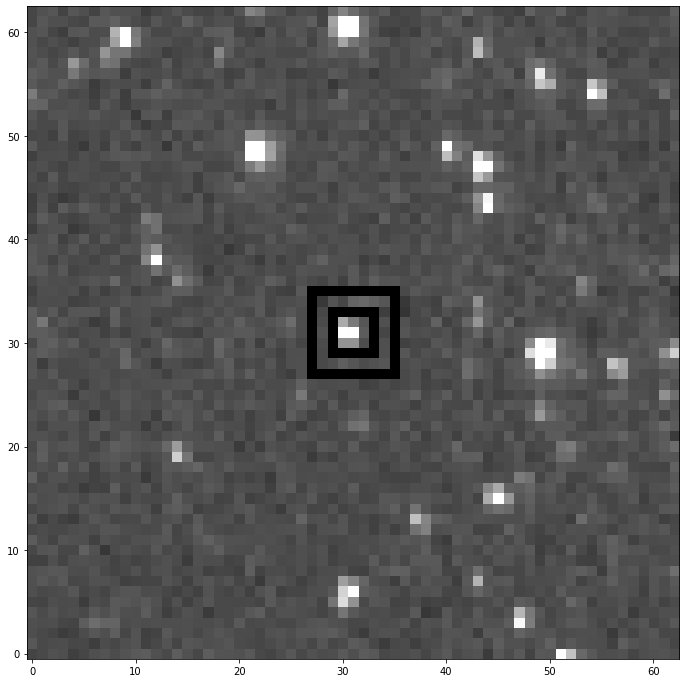

In [29]:
tot_star_real1, fsq1, = get_flux_counts_new(mode='real', pt1_1=29, pt1_2=33, pt2_1=33, pt2_2=29, dims=126, spacing_inner=0, spacing_outer=2)

Print BG-subtracted flux counts for each frame in the sequence.

In [27]:
tot_star_real1

[3279.0,
 2836.0,
 3293.5,
 2896.5,
 3254.0,
 3240.5,
 3172.5,
 2744.0,
 3140.0,
 2893.5,
 3285.0,
 3219.0,
 2905.5,
 2711.0,
 3287.5,
 31017.0,
 3245.0,
 3155.0,
 3169.0,
 3034.5,
 3282.0,
 3183.0,
 2987.0,
 3069.0,
 3210.0,
 3477.0,
 2974.5,
 2770.5,
 2923.0,
 3032.5,
 2936.0,
 2965.0,
 2597.5]